In [ ]:
from database.database import get_session, MediumArticle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
from transformers import BertTokenizer, BertModel
import numpy as np
import torch
from tqdm.notebook import tqdm
from rich.progress import track
from rich.progress import Progress

# Setup device - properly configure MPS for Apple Silicon
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set(style="whitegrid")
sns.set_context(
    "paper",
    rc={
        "font.size": 8,
        "axes.titlesize": 10,
        "axes.labelsize": 8,
        "fig.title_size": 13,
    },
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Using device: mps


In [87]:
all_articles = get_session().query(MediumArticle).all()
len(all_articles)

969

In [88]:
# to pandas
df = pd.read_sql_query(
    get_session().query(MediumArticle).statement,
    get_session().bind,
    index_col="id",
)
df.head()

,url_id,title,author_id,date_published,date_modified,date_created,description,publisher_type,is_free,claps,comments_count,full_article_text,read_time,type,num_images,tags
id,,,,,,,,,,,,,,,,
2,29571399,Hexagonal Architecture with Dotnet 6 — Part 2:...,2,2022-10-06 05:03:47.821,2022-10-09 05:59:49.460,2022-10-06 05:03:47.821,We go to Visual Studio and click “Create a new...,Organization,True,3,0,We go to Visual Studio and click “Create a new...,2,NewsArticle,2,"[Dotnet, Hexagonal Architecture, Cqrs, Ddd]"
4,29571469,Why Scotland’s Muslim Women Should be Followin...,6,2022-10-06 23:44:10.874,2022-10-07 00:53:47.320,2022-10-06 23:44:10.874,Picture this: It is 11pm and you stop at a ser...,Organization,True,50,1,And how to do it…\n\n![](https://miro.medium.c...,5,NewsArticle,3,"[Gender, Transgender, Scotland, Law, Muslim]"
5,29571486,Mongodb Relational Documents with Node.js and ...,8,2022-10-06 06:07:42.984,2022-10-09 10:10:56.185,2022-10-06 06:07:42.984,As a beginner many people are confused on how ...,Organization,True,2,0,![](https://miro.medium.com/v2/resize:fit:1400...,5,NewsArticle,9,"[Mongodb, Mongoose, Database, Nodejs, Mongodb ..."
6,29571441,Morpheus.Network Kickstarts KYC For Beta Maste...,9,2022-10-06 20:59:22.106,2024-02-20 21:25:06.545,2022-10-06 20:59:22.106,We’re thrilled to announce that the first stag...,Organization,True,410,2,![](https://miro.medium.com/v2/resize:fit:700/...,5,NewsArticle,6,[]
7,29571501,Why Having an Affair is Easy Until It Isn’t - ...,12,2022-10-06 07:12:37.354,2024-01-08 20:40:38.553,2022-10-06 07:12:37.354,When you get married you make covenants and vo...,Organization,True,142,1,![](https://miro.medium.com/v2/1*jE2H3k-Lk49Do...,7,NewsArticle,3,"[Infidelity, Love, Marriage, Divorce, Mental H..."


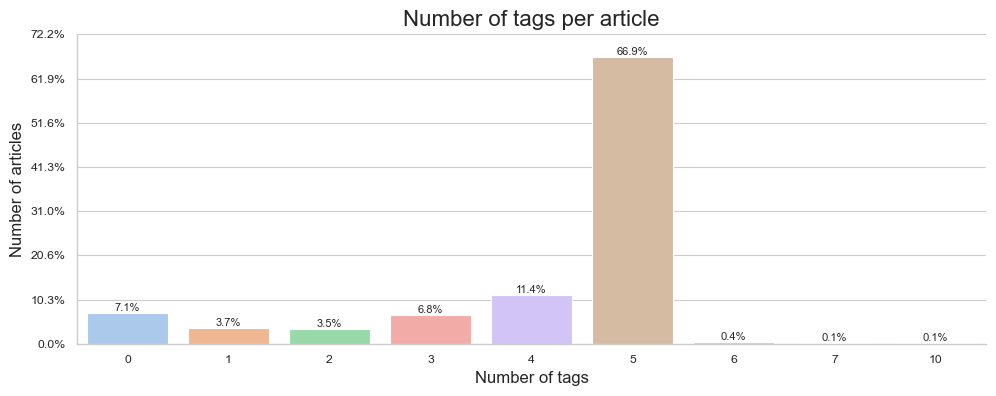

In [89]:
# Create a new Series with the number of tags per article
tag_counts = df["tags"].apply(len)

# Calculate percentages for each count
total_articles = len(df)
value_counts = tag_counts.value_counts()
percentages = (value_counts / total_articles) * 100

# Create a seaborn plot to show tag count distribution
plt.figure(figsize=(10, 4))

# Fix the countplot with proper parameter usage
ax = sns.countplot(x=tag_counts, hue=tag_counts, palette="pastel", legend=False)
ax.set_title("Number of tags per article", fontsize=16)
ax.set_xlabel("Number of tags", fontsize=12)
ax.set_ylabel("Number of articles", fontsize=12)

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_articles) * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width()/2., height), 
                ha='center', va='bottom')

# Fix y-axis ticks to show percentages properly
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # First set the tick positions
ax.set_yticklabels([f'{(y/total_articles)*100:.1f}%' for y in y_ticks])

# Improve readability of labels
sns.despine()
plt.tight_layout()
plt.show()

From now on we only consider those articles with at least one tag.

In [90]:
# delete all articles without tags
df = df[df["tags"].apply(len) > 0]
df.shape

(900, 16)

In [91]:
df.head()

,url_id,title,author_id,date_published,date_modified,date_created,description,publisher_type,is_free,claps,comments_count,full_article_text,read_time,type,num_images,tags
id,,,,,,,,,,,,,,,,
2,29571399,Hexagonal Architecture with Dotnet 6 — Part 2:...,2,2022-10-06 05:03:47.821,2022-10-09 05:59:49.460,2022-10-06 05:03:47.821,We go to Visual Studio and click “Create a new...,Organization,True,3,0,We go to Visual Studio and click “Create a new...,2,NewsArticle,2,"[Dotnet, Hexagonal Architecture, Cqrs, Ddd]"
4,29571469,Why Scotland’s Muslim Women Should be Followin...,6,2022-10-06 23:44:10.874,2022-10-07 00:53:47.320,2022-10-06 23:44:10.874,Picture this: It is 11pm and you stop at a ser...,Organization,True,50,1,And how to do it…\n\n![](https://miro.medium.c...,5,NewsArticle,3,"[Gender, Transgender, Scotland, Law, Muslim]"
5,29571486,Mongodb Relational Documents with Node.js and ...,8,2022-10-06 06:07:42.984,2022-10-09 10:10:56.185,2022-10-06 06:07:42.984,As a beginner many people are confused on how ...,Organization,True,2,0,![](https://miro.medium.com/v2/resize:fit:1400...,5,NewsArticle,9,"[Mongodb, Mongoose, Database, Nodejs, Mongodb ..."
7,29571501,Why Having an Affair is Easy Until It Isn’t - ...,12,2022-10-06 07:12:37.354,2024-01-08 20:40:38.553,2022-10-06 07:12:37.354,When you get married you make covenants and vo...,Organization,True,142,1,![](https://miro.medium.com/v2/1*jE2H3k-Lk49Do...,7,NewsArticle,3,"[Infidelity, Love, Marriage, Divorce, Mental H..."
11,29571511,Building responsive Flutter desktop and web ap...,31,2022-10-06 00:12:53.310,2022-12-08 12:06:54.192,2022-10-06 00:12:53.310,Flutter has grown over the years. compared wit...,Organization,True,64,2,![](https://miro.medium.com/v2/resize:fit:1400...,3,NewsArticle,3,"[Flutter, Responsive Design, Desktop, Web]"


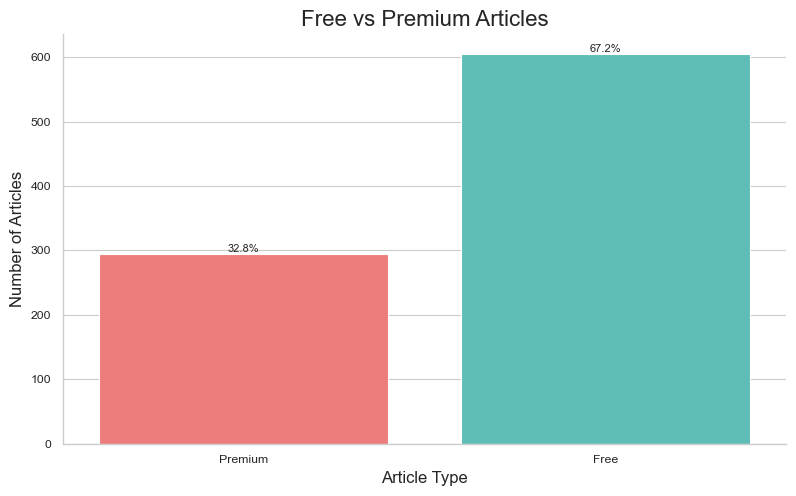

In [92]:
# Count free vs premium articles
free_premium_counts = df['is_free'].value_counts()
free_premium_percentages = (free_premium_counts / len(df)) * 100

# Create figure
plt.figure(figsize=(8, 5))

# Create bar plot with proper hue parameter to avoid the warning
ax = sns.countplot(x='is_free', hue='is_free', data=df, palette=["#ff6b6b", "#4ecdc4"], legend=False)
ax.set_title("Free vs Premium Articles", fontsize=16)
ax.set_xlabel("Article Type", fontsize=12)
ax.set_ylabel("Number of Articles", fontsize=12)

# Set more readable x-axis labels
ax.set_xticks([0, 1])  # Set the tick positions
ax.set_xticklabels(['Premium', 'Free'])

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / len(df)) * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width()/2., height), 
                ha='center', va='bottom')

# Improve readability of labels
sns.despine()
plt.tight_layout()
plt.show()

## Preprocessing

In [165]:
import markdown
from IPython.display import display, HTML
from bs4 import BeautifulSoup

def markdown_to_plain_text(md_text):
    html = markdown.markdown(md_text)
    soup = BeautifulSoup(html, "html.parser")
    return soup.get_text()

df["full_article_text"] = df["full_article_text"].apply(markdown_to_plain_text)

In [166]:
from fast_langdetect import detect, detect_multilingual, LangDetector, LangDetectConfig, DetectError

# Initialize the language detector
config = LangDetectConfig()
detector = LangDetector(config)
langs = []
# Detect the language of the first 10 articles
for article in df["full_article_text"]:
    try:
        lang = detector.detect(article[:100].replace("\n", " "))
        langs.append(lang["lang"])
    except DetectError as e:
        print(f"Error detecting language: {e}")

df["language"] = langs

In [187]:
# filter for english articles
df = df[df["language"] == "en"]
df.shape

(837, 21)

In [ ]:
# preprocess the text
import spacy

# spacy.cli.download("en_core_web_sm")

# TODO multi lang
nlp = spacy.load("en_core_web_sm")
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

# Apply preprocessing to the full article text
df['processed_text'] = df['full_article_text'].apply(preprocess_text)
df[['full_article_text', 'processed_text']].head(5)

,full_article_text,processed_text
id,,
2,We go to Visual Studio and click “Create a new...,Visual Studio click create new project select ...
4,And how to do it…\nPicture this: It is 11pm an...,\n picture 11 pm stop service station Scottish...
5,As a beginner many people are confused on how ...,beginner people confuse relate document Mongod...
7,When you get married you make covenants and vo...,marry covenant vow spouse honor support commit...
11,Flutter has grown over the years. compared wit...,flutter grow year compare version 1.0 realise ...


In [167]:
tags = df["tags"].apply(lambda x: [tag.lower() for tag in x])

In [168]:
df.head(5)

,url_id,title,author_id,date_published,date_modified,date_created,description,publisher_type,is_free,claps,comments_count,full_article_text,read_time,type,num_images,tags,differences,article_embeddings,tag_embeddings,language
id,,,,,,,,,,,,,,,,,,,,
2,29571399,Hexagonal Architecture with Dotnet 6 — Part 2:...,2,2022-10-06 05:03:47.821,2022-10-09 05:59:49.460,2022-10-06 05:03:47.821,We go to Visual Studio and click “Create a new...,Organization,True,3,0,We go to Visual Studio and click “Create a new...,2,NewsArticle,2,"[Dotnet, Hexagonal Architecture, Cqrs, Ddd]",11.703608,"[[-0.060173586, -0.28805315, 0.42061427, 0.184...","[[0.11027783, -0.44333944, 0.29028797, 0.18794...",en
4,29571469,Why Scotland’s Muslim Women Should be Followin...,6,2022-10-06 23:44:10.874,2022-10-07 00:53:47.320,2022-10-06 23:44:10.874,Picture this: It is 11pm and you stop at a ser...,Organization,True,50,1,And how to do it…\nPicture this: It is 11pm an...,5,NewsArticle,3,"[Gender, Transgender, Scotland, Law, Muslim]",13.853088,"[[0.15967774, -0.53129274, 0.37580797, 0.27690...","[[0.2353435, 0.08997397, 0.89488, -0.1541188, ...",en
5,29571486,Mongodb Relational Documents with Node.js and ...,8,2022-10-06 06:07:42.984,2022-10-09 10:10:56.185,2022-10-06 06:07:42.984,As a beginner many people are confused on how ...,Organization,True,2,0,As a beginner many people are confused on how ...,5,NewsArticle,9,"[Mongodb, Mongoose, Database, Nodejs, Mongodb ...",11.717603,"[[0.017702997, -0.45742273, 0.5035426, 0.12274...","[[-0.012821538, -0.7352127, 0.7772431, 0.18934...",en
7,29571501,Why Having an Affair is Easy Until It Isn’t - ...,12,2022-10-06 07:12:37.354,2024-01-08 20:40:38.553,2022-10-06 07:12:37.354,When you get married you make covenants and vo...,Organization,True,142,1,When you get married you make covenants and vo...,7,NewsArticle,3,"[Infidelity, Love, Marriage, Divorce, Mental H...",12.600446,"[[0.06549599, -0.58549994, 0.5335225, -0.00829...","[[0.18052152, -0.49806666, 0.50039536, -0.3814...",en
11,29571511,Building responsive Flutter desktop and web ap...,31,2022-10-06 00:12:53.310,2022-12-08 12:06:54.192,2022-10-06 00:12:53.310,Flutter has grown over the years. compared wit...,Organization,True,64,2,Flutter has grown over the years. compared wit...,3,NewsArticle,3,"[Flutter, Responsive Design, Desktop, Web]",13.053739,"[[-0.038229823, -0.35069737, 0.4500929, 0.2914...","[[0.61765397, -0.8602877, 0.12674096, 0.030992...",en


## Bert text embedding vs tag embedding

In [169]:
model = BertModel.from_pretrained('bert-base-multilingual-cased')
model = model.to(device)

def get_tag_embeddings(article: MediumArticle):
    """
    Get the tag embeddings for a given article.
    """
    # Tokenize the tags
    tokens = tokenizer(article.tags, padding=True, truncation=True, return_tensors="pt")
    
    # Move tokens to device
    tokens = {k: v.to(device) for k, v in tokens.items()}
    
    # Get the embeddings
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Get the mean of the last hidden state and move back to CPU for numpy
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    
    return embeddings

get_tag_embeddings(df.iloc[0]).shape

(4, 768)

In [180]:
def get_article_embedding(article: MediumArticle):
    text = article.processed_text
    tokens = tokenizer.tokenize(text)
    max_tokens = 510
    if len(tokens) > max_tokens:
        embeddings = []
        for i in range(0, len(tokens), max_tokens):
            chunk_tokens = tokens[i:i + max_tokens]
            chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
            inputs = tokenizer(chunk_text, return_tensors="pt", padding=True, truncation=True)
            # Move inputs to device
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
            # Move back to CPU for numpy
            chunk_embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(chunk_embedding)
        return np.mean(embeddings, axis=0)
    else:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        # Move inputs to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        # Move back to CPU for numpy
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

get_article_embedding(df.iloc[0]).shape

(1, 768)

In [181]:
# calc differences between article and tags
def calc_differences(article_embedding, tag_embeddings):
    differences = []
    for tag_embedding in tag_embeddings:
        # Calculate the difference
        diff = article_embedding - tag_embedding
        # Calculate the norm (magnitude) of the difference
        norm = np.linalg.norm(diff)
        differences.append(norm)
    return differences

calc_differences(
    get_article_embedding(df.iloc[0]),
    get_tag_embeddings(df.iloc[0])
)

[np.float32(11.6979885),
 np.float32(12.898958),
 np.float32(12.014932),
 np.float32(13.407975)]

In [182]:
# Calculate differences for all articles, then average them and plot the differences between free and premium using a bar plot
all_differences = []
all_article_embeddings = []
all_tag_embeddings = []

# Create a progress display
with Progress() as progress:
    # Create a task with appropriate description
    task = progress.add_task("[cyan]Calculating article-tag differences...", total=len(df))
    
    for article in df.itertuples():
        tag_embeddings = get_tag_embeddings(article)
        article_embedding = get_article_embedding(article)
        differences = calc_differences(article_embedding, tag_embeddings)

        all_differences.append(np.mean(differences))
        all_article_embeddings.append(article_embedding)
        all_tag_embeddings.append(tag_embeddings)
        
        # Update progress
        progress.update(task, advance=1)

# Add differences to dataframe
df["differences"] = all_differences
df["article_embeddings"] = all_article_embeddings
df["tag_embeddings"] = all_tag_embeddings

Output()

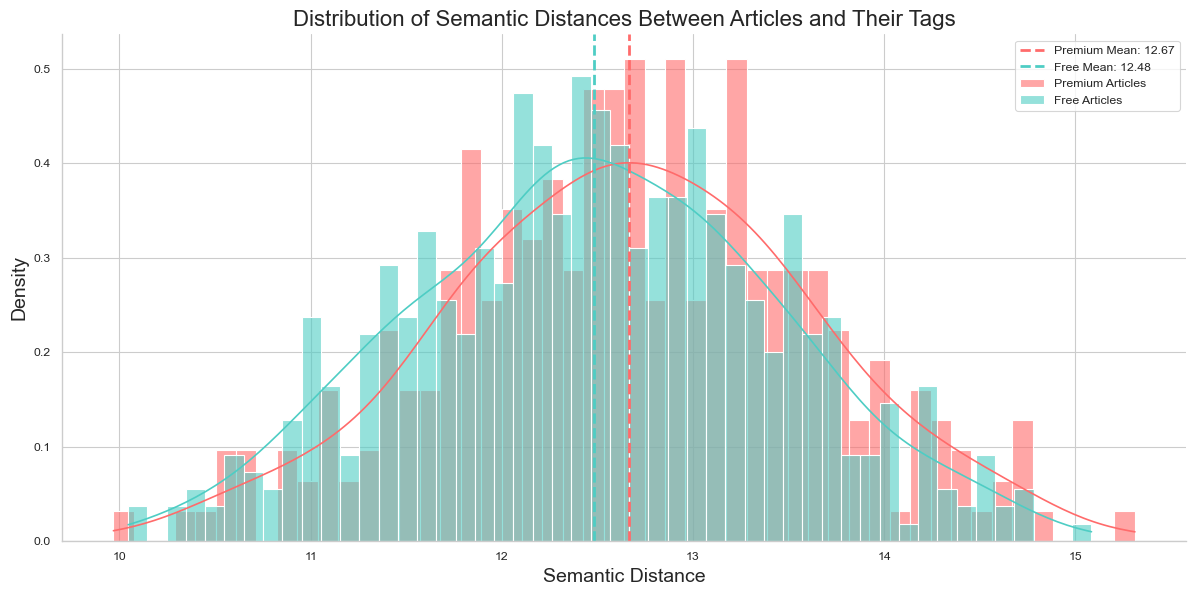

In [189]:
free_diffs = df[df["is_free"] == 1]["differences"]
premium_diffs = df[df["is_free"] == 0]["differences"]

plt.figure(figsize=(12, 6))

# Create histograms for both distributions
sns.histplot(premium_diffs, kde=True, color='#ff6b6b', alpha=0.6, label='Premium Articles', 
             bins=50, stat='density')
sns.histplot(free_diffs, kde=True, color='#4ecdc4', alpha=0.6, label='Free Articles', 
             bins=50, stat='density')

# Add vertical lines for the means
plt.axvline(premium_diffs.mean(), color='#ff6b6b', linestyle='--', linewidth=2,
            label=f'Premium Mean: {premium_diffs.mean():.2f}')
plt.axvline(free_diffs.mean(), color='#4ecdc4', linestyle='--', linewidth=2,
            label=f'Free Mean: {free_diffs.mean():.2f}')

# Set plot labels and title
plt.title('Distribution of Semantic Distances Between Articles and Their Tags', fontsize=16)
plt.xlabel('Semantic Distance', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

# Improve overall appearance
sns.despine()
plt.tight_layout()
plt.show()

Total unique tags: 1979


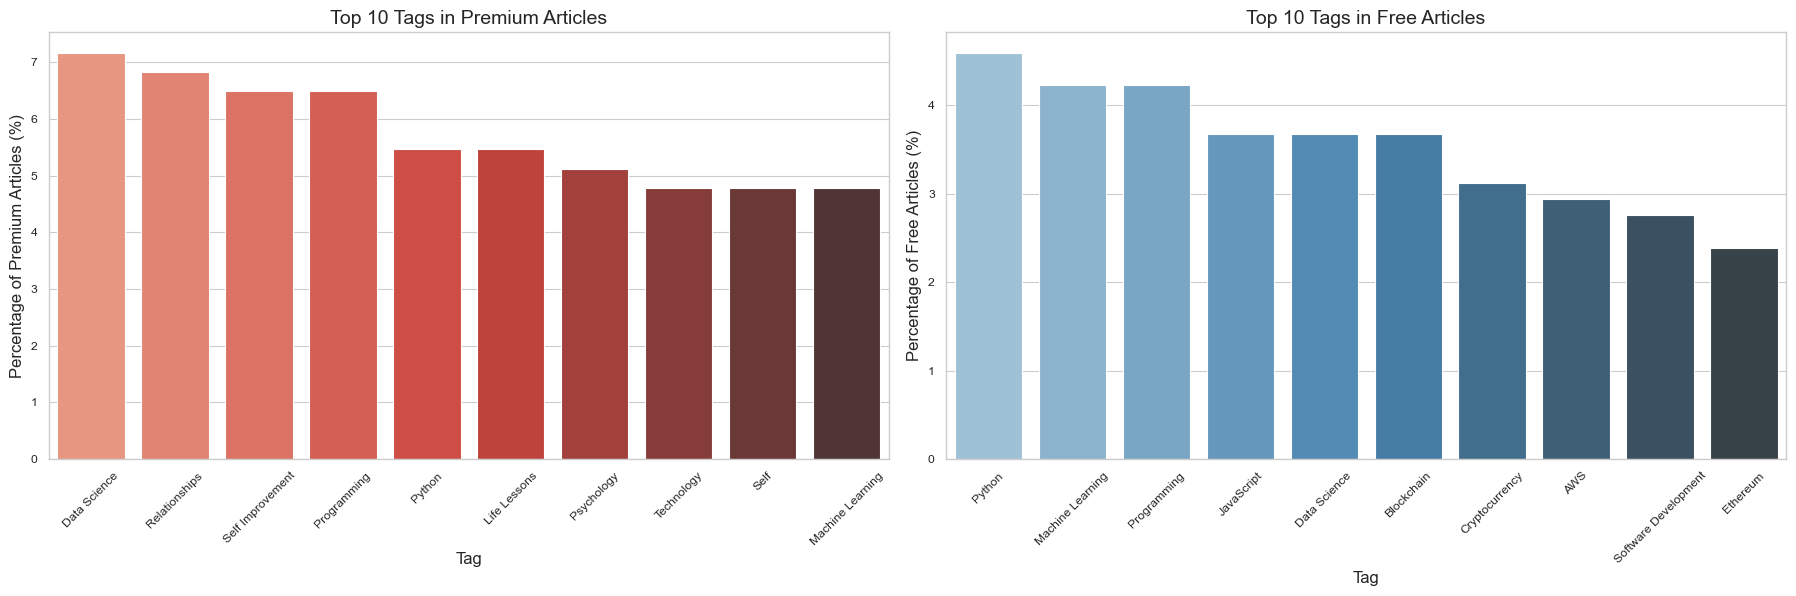

In [190]:
from collections import Counter

def get_tag_freq(articles):
    return Counter(tag for tags in articles['tags'] for tag in tags)

all_tags = set(tag for tags in df['tags'] for tag in tags)
print(f"Total unique tags: {len(all_tags)}")

# Split data
premium_articles = df[~df['is_free']]
free_articles = df[df['is_free']]

premium_tags = get_tag_freq(premium_articles)
free_tags = get_tag_freq(free_articles)

# Get top 10 tags
top_premium = pd.DataFrame(premium_tags.most_common(10), columns=['Tag', 'Count'])
top_free = pd.DataFrame(free_tags.most_common(10), columns=['Tag', 'Count'])

# Calculate percentages
top_premium['Percentage'] = top_premium['Count'] / len(premium_articles) * 100
top_free['Percentage'] = top_free['Count'] / len(free_articles) * 100

# Create visualizations of tag distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Premium tags
sns.barplot(x='Tag', y='Percentage', data=top_premium.head(10), ax=ax1, palette='Reds_d')
ax1.set_title('Top 10 Tags in Premium Articles', fontsize=14)
ax1.set_xlabel('Tag', fontsize=12)
ax1.set_ylabel('Percentage of Premium Articles (%)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Free tags
sns.barplot(x='Tag', y='Percentage', data=top_free.head(10), ax=ax2, palette='Blues_d')
ax2.set_title('Top 10 Tags in Free Articles', fontsize=14)
ax2.set_xlabel('Tag', fontsize=12)
ax2.set_ylabel('Percentage of Free Articles (%)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [192]:
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Stack all embeddings into a single numpy array
article_embeddings_array = np.vstack(df['article_embeddings'].values)

# Create metadata (tags) for each article
metadata = []
for tags in df['tags']:
    # replace any break lines with nothing
    tags = [tag.replace('\n', '').replace('\r', '') for tag in tags]
    metadata.append(', '.join(tags))

print(len(metadata))
print(len(article_embeddings_array))

# Create the writer
writer = SummaryWriter('runs/medium_embeddings')

# Add embeddings with metadata without header
writer.add_embedding(
    mat=article_embeddings_array,
    metadata=metadata,
    tag='article_embeddings'
)

writer.close()
print("Embeddings successfully added to TensorBoard")

837
837
Embeddings successfully added to TensorBoard


## Bertopic

In [185]:
docs = df['processed_text'].tolist()
topic_model = BERTopic(language="multilingual")
topics, probabilities = topic_model.fit_transform(docs)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [186]:
topic_info = topic_model.get_topic_info()
print("Topic Information:")
print(topic_info)

Topic Information:
   Topic  Count                          Name  \
0     -1    132          -1_use_user_new_time   
1      0    439      0_datum_model_create_use   
2      1    270       1_people_like_time_know   
3      2     35  2_crypto_exchange_token_coin   
4      3     24                3_de_que_eu_la   

                                      Representation  \
0  [use, user, new, time, need, like, change, wor...   
1  [datum, model, create, use, file, need, data, ...   
2  [people, like, time, know, life, feel, thing, ...   
3  [crypto, exchange, token, coin, pool, wallet, ...   
4        [de, que, eu, la, um, da, uma, não, em, нь]   

                                 Representative_Docs  
0  [risk wildfire storm hurricane flood heatwave ...  
1  [introduction \n time ago share article summar...  
2  [consider fortunate person winner demographic ...  
3  [\n Update 11/11/2022 spectacular collapse wee...  
4  [escrito por Lucas Travi Raul Wagner 05/08/202...  
